# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

#from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject


In [2]:
load_module = True
kernel = "alpha"

if load_module:
    if kernel == "alpha":
        module_name = "edlif_psc_alpha_0_module"
        neuron_model = ["edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml.nestml"]
    elif kernel == "exp":
        module_name = "edlif_psc_exp_1_module"
        neuron_model = ["edlif_psc_exp_percent1_nestml__with_ed_stdp1_nestml.nestml"]
    nest.Install(module_name)
    
    neuron_id = 0
else:
    neuron_model = [
        "edlif_psc_base.nestml", 
        "edlif_psc_nonlineardendrite.nestml",
        "edlif_psc_supply_state.nestml",
        "edlif_psc_supply_inline.nestml",
        "edlif_psc_percent.nestml",
        "../network/models/neurons/edlif_psc_alpha_percent.nestml"
    ]
    neuron_id = 5
    generate_nest_target(input_path=neuron_model[neuron_id],
                         target_path="/tmp/nestml-component",
                         logging_level="INFO",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
    
    nest.Install("nestmlmodule")


Nov 22 02:42:34 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


In [3]:
def expected_fr(t_ref, tau_m, v_th, v_res, i_e, c):
    fr = (t_ref - tau_m*np.log(1-((v_th - v_res)/(i_e*(tau_m/c)))))**-1
    return fr*1000

In [4]:
nest.ResetKernel()
nest.set_verbosity("M_WARNING")

neuron_model_name = neuron_model[neuron_id].split("/")[-1].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

#simulation params
neuron = nest.Create(neuron_model_name)
sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)
simtime = 2000.*1


Using neuron model: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml
resolution time: 0.1


running neuron with gamma = 0
running neuron with gamma = 20
running neuron with gamma = 50
running neuron with gamma = 100


/tmp/ipykernel_10707/3752075370.py:144: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


spikes times: 244
firing rate: 122.0


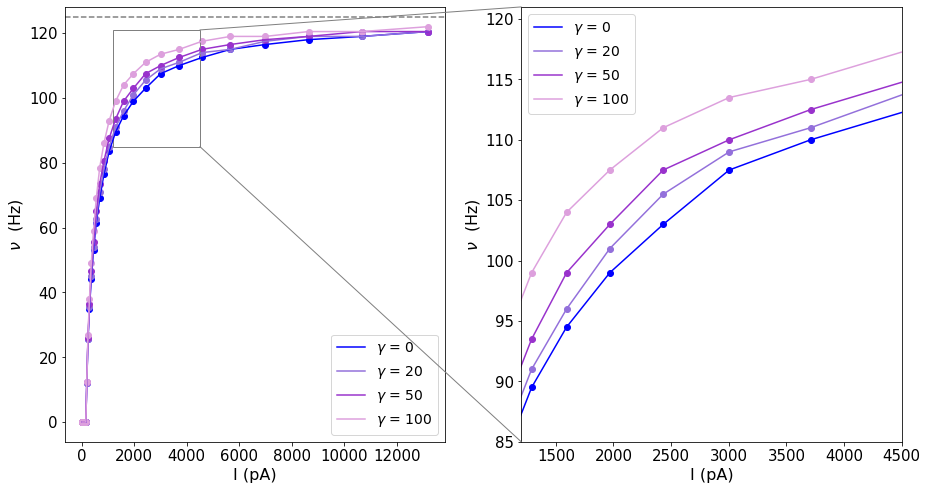

In [5]:
import matplotlib.patches as patches

verbose = 0

gamma_list = [0, 20, 50, 100]  # gamma 

# current generator
#current_list = np.linspace(0, 12000, num=30)  # pA
current_list = np.logspace(1, 4.12, num=35)  # pA

# rate list
rate_list = {}

#with nest.RunManager():
for gamma in gamma_list:
    rate_list.setdefault(gamma, [])
    print(f"running neuron with gamma = {gamma}")
    for current in current_list:
        nest.ResetKernel()
        nest.resolution = 0.1 # resolution
        resolution = nest.GetKernelStatus()["resolution"] 

        #simulation params
        neuron = nest.Create(neuron_model_name)
        sr = nest.Create("spike_recorder")
        nest.Connect(neuron, sr)
        #simtime = 2000.*1
        
        # external source
        cgs = nest.Create('dc_generator')
        cgs.set({"amplitude": current})
        nest.Connect(cgs, neuron)


        # neuron params
        neuron.fix_atp = 0
        neuron.ATP = 100
        neuron.tau_m = 20 #20
        neuron.tau_syn_ex = 6
        neuron.tau_syn_in = 6
        neuron.C_m = 250 #250
        neuron.t_ref =  8 #2
        max_rate = (neuron.t_ref)**-1*1000

        # energy params
        neuron.K_ATP = 1
        neuron.tau_ap = 60
        neuron.E_ap = 8
        neuron.E_rp = 5
        neuron.E_hk = 5
        neuron.E_syn_ex = neuron.E_ap/2
        neuron.E_syn_in = neuron.E_ap/2
        neuron.tau_syn_atp_ex = 60
        neuron.tau_syn_atp_in = 60
        neuron.I_e = 0
        neuron.gamma = gamma
        
        nest.Simulate(simtime)
        #nest.Run(simtime)
        spike_times = nest.GetStatus(sr, keys='events')[0]['times']
        rate_list[gamma].append(len(spike_times)/simtime * 1000)
        if verbose:
            print(f"injected current = {current}")  
            print("spike times")
            print(spike_times)
            print("rate list")
            print(rate_list)
            print("rate")
            print(len(spike_times)/simtime * 1000)


fontsize = 16
ls = 14
ts = 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
#c = ['blue', 'yellow','orange', 'red']
c = ['blue', 'mediumpurple','darkorchid','plum']
for n in range(len(ax)):
    for k, gamma in enumerate(gamma_list):
        ax[n].plot(current_list, rate_list[gamma][:], label=r"$\gamma$ = " + f"{gamma}", c = c[k])
        ax[n].scatter(current_list, rate_list[gamma][:], c = c[k])
        ax[n].set_ylabel(r"$\nu$ " +" (Hz)", fontsize=fontsize)
        ax[n].set_xlabel("I (pA)", fontsize=fontsize)

    ax[n].axhline(y=max_rate, c="gray", ls="--")
    ax[n].legend(fontsize=ls)
    ax[n].tick_params(axis='both', labelsize=ts)
    if n == 0:
        min_x = 1200
        min_y = 85
        max_x = 4500
        max_y = 121
        width = max_x - min_x
        height = max_y - min_y
        ax[n].add_patch(
            patches.Rectangle(
                xy=(min_x, min_y),  # point of origin.
                width=width, height=height, linewidth=1,
                color='gray', fill=False))
        #ax[n].arrow(x=max_x,
        #           y=min_y,
        #           dx=13000,
        #           dy=0)
    elif n == 1:
        ax[n].set_xlim([min_x, max_x])
        ax[n].set_ylim([min_y, max_y])
        #ax[n].set_xlim([300, 1000])
        #ax[n].set_ylim([0, 100])
    
xyA_min = [max_x, min_y]
xyB_min = [min_x, min_y]
xyA_max = [max_x, max_y]
xyB_max = [min_x, max_y]
transFigure = fig.transFigure.inverted()
coord1_min = transFigure.transform(ax[0].transData.transform(xyA_min))
coord2_min = transFigure.transform(ax[1].transData.transform(xyB_min))
coord1_max = transFigure.transform(ax[0].transData.transform(xyA_max))
coord2_max = transFigure.transform(ax[1].transData.transform(xyB_max))
arrow_min = patches.FancyArrowPatch(
    coord1_min,  # posA
    coord2_min,  # posB
    shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
    shrinkB=0,  # so head is exactly on posB (default shrink is 2)
    transform=fig.transFigure,
    color="gray",
    arrowstyle="-",  # "normal" arrow
    mutation_scale=30,  # controls arrow head size
    linewidth=1,
)
arrow_max = patches.FancyArrowPatch(
    coord1_max,  # posA
    coord2_max,  # posB
    shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
    shrinkB=0,  # so head is exactly on posB (default shrink is 2)
    transform=fig.transFigure,
    color="gray",
    arrowstyle="-",  # "normal" arrow
    mutation_scale=30,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow_min)
fig.patches.append(arrow_max)

fig.show()
plt.savefig(f"rates_diff_gammas", dpi=144,
           pad_inches=0)


print(f'spikes times: {len(spike_times)}')
print(f'firing rate: {len(spike_times)/simtime * 1000}')